<a href="https://colab.research.google.com/github/JanieTran/deeplearning.ai_TensorFlowInPractice/blob/master/4%20-%20Sequences%2C%20Time%20Series%20and%20Prediction/W2L3%20-%20DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

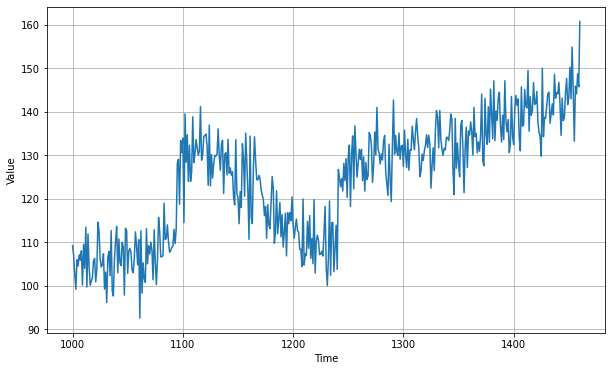

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

3-layer sequential DNN

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 27ms/step - loss: 609.3200
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 55.8324
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 45.0132
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 43.6034
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 43.1452
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 42.5099
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 43.8255
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 41.9721
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 41.9383
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 42.5359
Epoch 11/100
31/31 [==============================] - 0s 8ms/step - loss: 42.4549
Epoch 12/100
31/31 [==============================] - 0s 8ms/step - loss: 41.1940
Epoch 13/100
31/31 [===

Plot predicted against true results

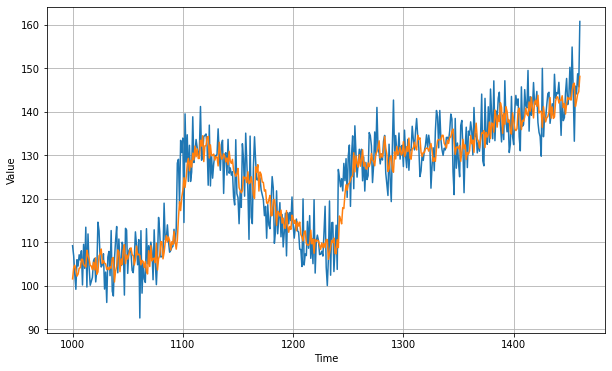

In [7]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.587409

Same NN but with `LearningRateScheduler`

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 19ms/step - loss: 73.3991
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 71.0581
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 70.3659
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 70.0417
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 69.7147
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 69.6883
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 69.9417
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 69.3641
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 69.7983
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 69.5365
Epoch 11/100
31/31 [==============================] - 0s 8ms/step - loss: 69.1863
Epoch 12/100
31/31 [==============================] - 0s 8ms/step - loss: 69.6072
Epoch 13/100
31/31 [====

Plot loss against learning rate

(1e-08, 0.001, 0.0, 300.0)

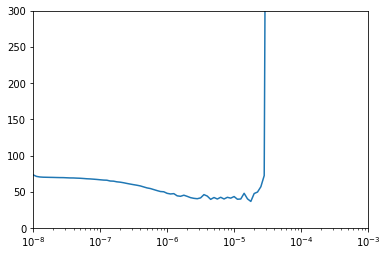

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

Training using the observed optimal learning rate (`8e-6`) for 500 epochs

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

Plot loss against epoch to observe loss over time

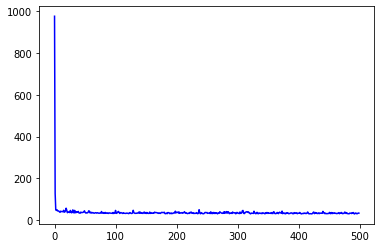

In [12]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

Remove the first 10 losses

[42.56823793784859, 40.865101332517014, 40.69555345908883, 41.062366009741716, 39.68522755731012, 46.93007466424372, 37.81107084923184, 39.32057948554914, 44.344829614383656, 56.8396193199551, 47.311745268045016, 35.33501056789123, 37.57632653934439, 37.318206885426314, 40.79493107746557, 35.85162243400652, 46.080984182456106, 39.3100214378121, 34.71598709735674, 37.15047300673023, 48.91389916016883, 36.89342489340871, 34.14789626917888, 46.33581661735613, 35.00398382993089, 40.7117324396507, 35.99474528204534, 40.01285602530253, 38.50198788986992, 41.50586070031235, 34.116968843125804, 33.535212263126965, 33.190346519234254, 38.00326923488342, 35.73159245756484, 36.377644167241364, 36.252153919652564, 37.363484097510266, 39.36939566700729, 44.29783821499225, 37.987370048601605, 34.05198359538599, 33.88435801869815, 35.492108767794576, 34.35127573701524, 36.78522320776871, 44.25082217344304, 43.2181739964436, 34.687689901135634, 37.33850256929693, 34.18945682171694, 36.786109365876186,

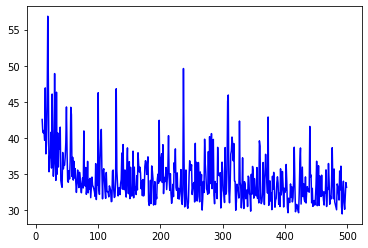

In [13]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

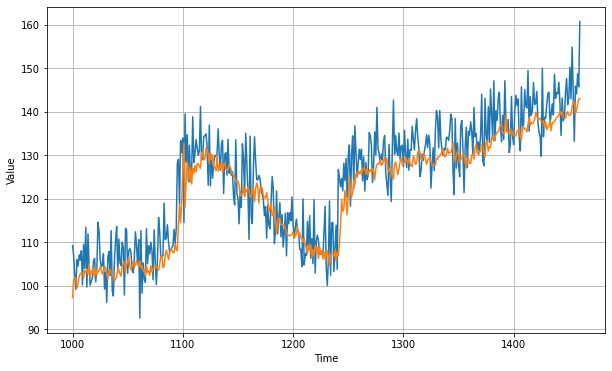

In [14]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.971838